# VisionBlock

> Fill in a module description here


In [ ]:
#| default_exp vision.VisionBlock

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import os
import sys
import random
import gc
import h5py
import torch
import torchvision
import torch.nn as nn
import gdown
import zipfile
from sklearn.model_selection import train_test_split
import ujson
import torchvision.transforms as transforms
from fastcore.utils import *
from fedai.vision.downloader import *

In [ ]:
#| export
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

<torch._C.Generator>

## Vision Block

In [ ]:
# #| export
# class VisionBlock(torch.utils.data.Dataset):
#     def __init__(self, cfg, id, train= True, download= True, transform=None):
#         self.cfg = cfg
#         self.config_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name , "config.json")
#         self.train_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name , "train")
#         self.test_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name, "test")
#         self.train = train
#         self.transform = transform
#         self.id = id

#         if download:
#             self.download_data()
        
#     def download_data(self):
#         self.downloader = VisionDownloader(self.cfg, self.transform)
#         if isinstance(self.downloader.dataset_content, (list, tuple, np.ndarray)):
#             train_data, test_data, stats = self.downloader.partition()
#             print('saving')
#             self.downloader.save_partitions(train_data, test_data, stats)
#             del self.downloader
#             gc.collect()
            
#     def tensorify(self, data):
#         X = torch.tensor(data['x'], dtype= torch.float32)
#         y = torch.tensor(data['y'], dtype= torch.int64)
#         return {'x': X, 'y': y}

#     def load_single_client_data(self, idx):
#         path, dir = (self.train_path, 'train') if self.train else (self.test_path, 'test')

#         with h5py.File(os.path.join(path, f'{dir}_data.h5'), 'r') as hf_file:
#             client_data = hf_file[f'client_{self.id}']
#             data = {key: client_data[key][idx] for key in client_data.keys()}
#             data = self.tensorify(data)
#         return data
    
#     def __getitem__(self, idx):
#         if idx < 0: # manage minus idx
#             idx = len(self) + idx
#         return self.load_single_client_data(idx)
    
#     def __len__(self):
#         path, dir = (self.train_path, 'train') if self.train else (self.test_path, 'test')
#         with h5py.File(os.path.join(path, f'{dir}_data.h5'), 'r') as hf_file:
#             client_data = hf_file[f'client_{self.id}']
#             return len(client_data['x'])

## New Vision Block
Any prepared dataset should be loadable using this class.

In [ ]:
#| export
class VisionBlock(torch.utils.data.Dataset):
    def __init__(self, cfg, id, train= True, download= True):
        self.cfg = cfg
        self.config_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name , "config.json")
        self.train_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name , "train")
        self.test_path = os.path.join(self.cfg.data.data_dir, self.cfg.data.name, "test")
        self.train = train
        self.id = id
        self.download_data()
        self.data = self.load_client_data()

    def url_mapper(self):
        k = "train" if self.train else "test"
        
        mapping = {
            "cifar10_hetro_30": 
                {"train": "https://drive.google.com/file/d/1Qq73WrxtlV3Wdg_USWY8inDb_R7reQcc/view?usp=sharing",
                 "test": "https://drive.google.com/file/d/1LDvB28hcWZOPQX_j0GbaCWKWe2Hd-0HN/view?usp=sharing",
                "zipname": f"cifar10_hetro_{k}_30.zip"
                 
                },

            "cifar10_20":
                {"train": "https://drive.google.com/file/d/14NBQaoW8etKzJ70Jf7BuANkR8MsN-j2Q/view?usp=sharing",
                 "test": "https://drive.google.com/file/d/1H1_QDLVXfipwauLEA8RJy1vfq4X8V9je/view?usp=sharing",
                 "zipname": f"cifar10_{k}_20.zip"
                },

            "mnist_rotated_40":
                {"train": "https://drive.google.com/file/d/1BtLqzHyeM6zSHpI_V9CVvERRH4yhsGKW/view?usp=sharing",
                 "test": "https://drive.google.com/file/d/1hDbHxlLZbCIhQHgfn-lXp6dCFKQT6MlK/view?usp=sharing",
                "zipname": f"mnist_rotated_{k}_40.zip"
                },

            "mnist_rotated_batched_40":
                {"train": "https://drive.google.com/file/d/10r4ZHFh4RaKTEPkC_x50e48A8gLS76d8/view?usp=sharing",
                 "test": "https://drive.google.com/file/d/1GeXdLUzaNlEoa5ki26ISUuLJJcoUjf53/view?usp=sharing",
                "zipname": f"mnist_rotated_batched_{k}_40.zip"
                }
                
            }
        if self.cfg.data.name not in mapping:
            raise ValueError(f"Dataset {self.cfg.data.name} not found in url mapping.")
        
        return mapping[self.cfg.data.name][k], mapping[self.cfg.data.name]['zipname']


    def download_data(self):
        
        url, zipname = self.url_mapper()
        if os.path.exists(os.path.join(self.cfg.data.data_dir, self.cfg.data.name, zipname)):
            return
        else:
            os.makedirs(os.path.join(self.cfg.data.data_dir, self.cfg.data.name), exist_ok= True)
               
        output = os.path.join(self.cfg.data.data_dir, self.cfg.data.name, zipname)
        gdown.download(url=url, output=output, fuzzy=True)

        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall(f'{self.train_path}' if self.train else f'{self.test_path}')

        print(f'Data downloaded and extracted to {self.train_path if self.train else self.test_path}')

    def tensorify(self, data):
        X = torch.tensor(data['x'], dtype= torch.float32)
        y = torch.tensor(data['y'], dtype= torch.int64)
        return {'x': X, 'y': y}

    def load_client_data(self):
        path, dir = (self.train_path, 'train') if self.train else (self.test_path, 'test')
        print(self.id)
        if self.id < 10:
            id = f'0000{self.id}'
        else:
            id = f'000{self.id}'

        with h5py.File(os.path.join(path, f'f_{id}'), 'r') as hf_file:
            x = hf_file['x'][:]
            y = hf_file['y'][:]
        return self.tensorify({'x': x, 'y': y})

    def __getitem__(self, idx):
        x = self.data['x'][idx]
        y = self.data['y'][idx]
        return {'x': x, 'y': y}

    def __len__(self):
        return len(self.data['y'])

In [ ]:
# from fedai.FLearner import *  # noqa: F403
from fedai.utils import * # noqa: F403
from omegaconf import OmegaConf

cfg = OmegaConf.load('./examples/cfg.yaml')
cfg.lr = 0.005
cfg.local_epochs = 5
cfg.tau = 0.1
cfg.model.name
cfg.batch_size = 32
cfg.data.name = "cifar10_hetro_30"

In [ ]:
#| hide
# ds = VisionBlock(cfg, 0, train= False)

Downloading...
From (original): https://drive.google.com/uc?id=1LDvB28hcWZOPQX_j0GbaCWKWe2Hd-0HN
From (redirected): https://drive.google.com/uc?id=1LDvB28hcWZOPQX_j0GbaCWKWe2Hd-0HN&confirm=t&uuid=b38ff1e7-89dc-4058-a058-e600d991c211
To: /home/ahmed/Ahmed-home/1- Projects/fedai/nbs/data/cifar10_hetro_30/cifar10_hetro_test_30.zip
100%|██████████| 36.2M/36.2M [00:03<00:00, 11.8MB/s]


Data downloaded and extracted to data/cifar10_hetro_30/test
0


In [ ]:
# ds[0]['x'].shape, ds[0]['y'].shape

(torch.Size([28, 28, 1]), torch.Size([]))

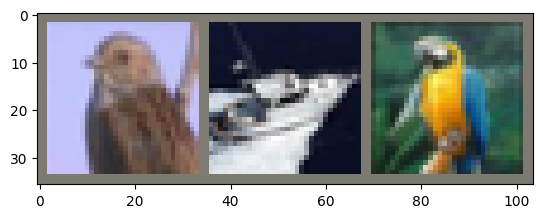

In [ ]:
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid

# def imshow(img):
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])

#     img = img.clone()  # Avoid modifying the original tensor
#     img = img * torch.tensor(std)[:, None, None] + torch.tensor(mean)[:, None, None]  # Unnormalize
#     npimg = img.numpy()
#     npimg = np.clip(npimg, 0, 1)  # Ensure valid range for imshow

#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# def show_n_client_samples(ds, n=3):
#     # generate 5 random indices between 0 and len(ds)
#     indices = random.sample(range(len(ds)), n)
#     imgs = []
#     for i in indices:
#         img = ds[i]['x']
#         imgs.append(img)
#     imshow(make_grid(imgs, nrow=3))

# show_n_client_samples(ds, n=3)


# Utilities

Those utilities are impoortant if you have an already available data loader. 

## Rotated Masked MNIST 40 Clients

In [ ]:
"""
Create rotated MNIST dataset for cross-silo FL.
Data loading code based on https://github.com/google/jax/blob/main/examples/datasets.py.
"""
import array  # Python array std library
import gzip
import os
from os import path
import struct
# import urllib
import urllib.request

import matplotlib.pyplot as plt
import numpy as np


# CVDF mirror of http://yann.lecun.com/exdb/mnist/
MNIST_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
# SAVE_DIR = './data/rotated_mnist'
DATA_DIR = '/tmp/datasets/rotated_mnist'
ROOT_SEED = int((np.e ** np.euler_gamma) ** np.pi * 1000)


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
  out_file = path.join(DATA_DIR, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, DATA_DIR))


def mnist(normalize=True, permute_train=False):
  """Download parse and process MNIST data to unit scale."""
  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, numDATA_DIR, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(numDATA_DIR, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(MNIST_URL + filename, filename)

  train_images = parse_images(path.join(DATA_DIR, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(DATA_DIR, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(DATA_DIR, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(DATA_DIR, "t10k-labels-idx1-ubyte.gz"))

  if normalize:
    train_images = train_images / np.float32(255.)
    test_images = test_images / np.float32(255.)

  if permute_train:
    perm = np.random.RandomState(ROOT_SEED).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels


def rotated_mnist(num_rotations=4, num_clients=40, inrot_shuffle=True, seed=ROOT_SEED,
                  save_dir=None):
  """Apply rotation to MNIST (no augmentation), split it into data siloes, and save for later."""
  train_images, train_labels, test_images, test_labels = mnist(permute_train=False)
  # Assume the examples can be evenly divided among clients
  assert len(train_images) % num_clients == len(train_labels) % num_clients == 0
  assert len(test_images) % num_clients == len(test_labels) % num_clients == 0
  # Also assume clients can be evenly divided into clusters; this ensures that
  # each client only have data from a certain rotation.
  assert num_clients % num_rotations == 0

  # Shuffle MNIST before rotations
  if inrot_shuffle:
    train_perm = np.random.RandomState(seed).permutation(len(train_images))
    test_perm = np.random.RandomState(seed + 1).permutation(len(test_images))
    train_images = train_images[train_perm]
    train_labels = train_labels[train_perm]
    test_images = test_images[test_perm]
    test_labels = test_labels[test_perm]

  # Cut images into `num_rotations` chunks, and rotate each chunk differently
  for k in range(num_rotations):
    left = k * len(train_images) // num_rotations
    right = (k + 1) * len(train_images) // num_rotations
    train_rot = np.rot90(train_images[left:right], axes=(1, 2), k=k)
    train_images[left:right] = train_rot

    left = k * len(test_images) // num_rotations
    right = (k + 1) * len(test_images) // num_rotations
    test_rot = np.rot90(test_images[left:right], axes=(1, 2), k=k)
    test_images[left:right] = test_rot

  # Split data into clients directly (we ensured that each client can have
  # data from the same rotation).
  # NOTE: also add a channel dimension for compatibility with Haiku conv.
  train_images = train_images.reshape(num_clients, -1, *train_images.shape[-2:], 1)
  train_labels = train_labels.reshape(num_clients, -1)
  test_images = test_images.reshape(num_clients, -1, *test_images.shape[-2:], 1)
  test_labels = test_labels.reshape(num_clients, -1)

  if save_dir is not None:
    if not path.exists(save_dir):
      os.makedirs(save_dir)
    np.save(path.join(save_dir, 'train_images'), train_images)
    np.save(path.join(save_dir, 'train_labels'), train_labels)
    np.save(path.join(save_dir, 'test_images'), test_images)
    np.save(path.join(save_dir, 'test_labels'), test_labels)
    print(f'Saved rotated MNIST to {save_dir}')

  return train_images, train_labels, test_images, test_labels


def rotated_patched_mnist(noise_level=0.5, patch_size=7, seed=ROOT_SEED, save_dir=None):
  # Shapes: data (K, n, 28, 28, 1), label (K, n)
  train_images, train_labels, test_images, test_labels = rotated_mnist()
  assert train_images.ndim == test_images.ndim == 5
  K, n, w, h, c = train_images.shape
  # For each client, add a client-specific heterogeneity (to make clients within
  # the same cluster further from each other).
  assert len(train_images) == len(train_labels) == len(test_images) == len(test_labels)

  rand = np.random.default_rng(seed=seed)
  mask_shape = (K, int(np.ceil(w / patch_size)), int(np.ceil(h / patch_size)), c)
  ### Noise level as fraction of area masked away ###
  noise_masks = rand.choice([0, 1], size=mask_shape, p=[1 - noise_level, noise_level])
  # Make patches via kronecker product
  noise_patches = np.kron(noise_masks, np.ones((patch_size, patch_size, 1)))
  noise_patches = noise_patches[:, :w, :h, :]   # Crop if necessary
  train_images = np.maximum(train_images, noise_patches[:, None])
  test_images = np.maximum(test_images, noise_patches[:, None])

  # Normalize again
  def min_max_normalize(images):
    min_val = np.min(images, axis=(2, 3, 4), keepdims=True)
    max_val = np.max(images, axis=(2, 3, 4), keepdims=True)
    return (images - min_val) / (max_val - min_val)

  train_images = min_max_normalize(train_images)
  test_images = min_max_normalize(test_images)

  if save_dir is not None:
    if not path.exists(save_dir):
      os.makedirs(save_dir)
    suffix = f'noise{noise_level}_patch{patch_size}_area'
    np.save(path.join(save_dir, f'train_images_{suffix}'), train_images)
    np.save(path.join(save_dir, f'train_labels_{suffix}'), train_labels)
    np.save(path.join(save_dir, f'test_images_{suffix}'), test_images)
    np.save(path.join(save_dir, f'test_labels_{suffix}'), test_labels)
    print(f'Saved rotated + patched MNIST to {save_dir}')

  return train_images, train_labels, test_images, test_labels

  

In [ ]:
#| hide
# xtr, ytr, xte, yte = rotated_patched_mnist()

In [ ]:
# #| hide
# import h5py
# for client_idx in range(len(xtr)):
#     client_data = torch.tensor(xtr[client_idx], dtype= torch.float32)
#     client_label = torch.tensor(ytr[client_idx], dtype= torch.int64)
#     dict_data = {'x': client_data, 'y': client_label}
#     # save as h5py
#     if client_idx < 10:
#         id = f'0000{client_idx}'
#     else:
#         id = f'000{client_idx}'

    
#     with h5py.File(os.path.join("mnist_rotated_batched_train_40", f'f_{id}'), 'w') as hf:
#         hf.create_dataset('x', data=client_data)
#         hf.create_dataset('y', data=client_label)
#     print(f"Client {id} data saved.")

Client 00000 data saved.
Client 00001 data saved.
Client 00002 data saved.
Client 00003 data saved.
Client 00004 data saved.
Client 00005 data saved.
Client 00006 data saved.
Client 00007 data saved.
Client 00008 data saved.
Client 00009 data saved.
Client 00010 data saved.
Client 00011 data saved.
Client 00012 data saved.
Client 00013 data saved.
Client 00014 data saved.
Client 00015 data saved.
Client 00016 data saved.
Client 00017 data saved.
Client 00018 data saved.
Client 00019 data saved.
Client 00020 data saved.
Client 00021 data saved.
Client 00022 data saved.
Client 00023 data saved.
Client 00024 data saved.
Client 00025 data saved.
Client 00026 data saved.
Client 00027 data saved.
Client 00028 data saved.
Client 00029 data saved.
Client 00030 data saved.
Client 00031 data saved.
Client 00032 data saved.
Client 00033 data saved.
Client 00034 data saved.
Client 00035 data saved.
Client 00036 data saved.
Client 00037 data saved.
Client 00038 data saved.
Client 00039 data saved.


In [ ]:
# #| hide
# # read h5py data 
# with h5py.File(os.path.join("./mnist_rotated_batched_train_40", f'f_00000'), 'r') as hf:
#     x = hf['x'][:]
#     y = hf['y'][:]

4


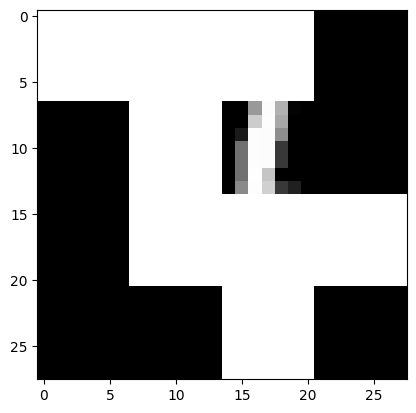

In [ ]:
# #| hide
# print(y[30])
# plt.imshow(x[30].reshape(28, 28), cmap='gray')

# plt.show()

## CIFAR hetro 30 Clients


In [ ]:
#| hide
import random
from collections import defaultdict

import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100


def get_datasets(data_name, dataroot, normalize=True, val_size=10000):
    """
    get_datasets returns train/val/test data splits of CIFAR10/100 datasets
    :param data_name: name of dataset, choose from [cifar10, cifar100]
    :param dataroot: root to data dir
    :param normalize: True/False to normalize the data
    :param val_size: validation split size (in #samples)
    :return: train_set, val_set, test_set (tuple of pytorch dataset/subset)
    """

    if data_name =='cifar10':
        normalization = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        data_obj = CIFAR10
    elif data_name == 'cifar100':
        normalization = transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        data_obj = CIFAR100
    else:
        raise ValueError("choose data_name from ['mnist', 'cifar10', 'cifar100']")

    trans = [transforms.ToTensor()]

    if normalize:
        trans.append(normalization)

    transform = transforms.Compose(trans)

    dataset = data_obj(
        dataroot,
        train=True,
        download=True,
        transform=transform
    )

    test_set = data_obj(
        dataroot,
        train=False,
        download=True,
        transform=transform
    )

    train_size = len(dataset) - val_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    return train_set, val_set, test_set


def get_num_classes_samples(dataset):
    """
    extracts info about certain dataset
    :param dataset: pytorch dataset object
    :return: dataset info number of classes, number of samples, list of labels
    """
    # ---------------#
    # Extract labels #
    # ---------------#
    if isinstance(dataset, torch.utils.data.Subset):
        if isinstance(dataset.dataset.targets, list):
            data_labels_list = np.array(dataset.dataset.targets)[dataset.indices]
        else:
            data_labels_list = dataset.dataset.targets[dataset.indices]
    else:
        if isinstance(dataset.targets, list):
            data_labels_list = np.array(dataset.targets)
        else:
            data_labels_list = dataset.targets
    classes, num_samples = np.unique(data_labels_list, return_counts=True)
    num_classes = len(classes)
    return num_classes, num_samples, data_labels_list


def gen_classes_per_node(dataset, num_users, classes_per_user=2, high_prob=0.6, low_prob=0.4):
    """
    creates the data distribution of each client
    :param dataset: pytorch dataset object
    :param num_users: number of clients
    :param classes_per_user: number of classes assigned to each client
    :param high_prob: highest prob sampled
    :param low_prob: lowest prob sampled
    :return: dictionary mapping between classes and proportions, each entry refers to other client
    """
    num_classes, num_samples, _ = get_num_classes_samples(dataset)

    # -------------------------------------------#
    # Divide classes + num samples for each user #
    # -------------------------------------------#
    # assert (classes_per_user * num_users) % num_classes == 0, "equal classes appearance is needed"
    count_per_class = (classes_per_user * num_users) // num_classes + 1
    class_dict = {}
    for i in range(num_classes):
        # sampling alpha_i_c
        probs = np.random.uniform(low_prob, high_prob, size=count_per_class)
        # normalizing
        probs_norm = (probs / probs.sum()).tolist()
        class_dict[i] = {'count': count_per_class, 'prob': probs_norm}

    # -------------------------------------#
    # Assign each client with data indexes #
    # -------------------------------------#
    class_partitions = defaultdict(list)
    for i in range(num_users):
        c = []
        for _ in range(classes_per_user):
            class_counts = [class_dict[i]['count'] for i in range(num_classes)]
            max_class_counts = np.where(np.array(class_counts) == max(class_counts))[0]
            c.append(np.random.choice(max_class_counts))
            class_dict[c[-1]]['count'] -= 1
        class_partitions['class'].append(c)
        class_partitions['prob'].append([class_dict[i]['prob'].pop() for i in c])
    return class_partitions


def gen_data_split(dataset, num_users, class_partitions):
    """
    divide data indexes for each client based on class_partition
    :param dataset: pytorch dataset object (train/val/test)
    :param num_users: number of clients
    :param class_partitions: proportion of classes per client
    :return: dictionary mapping client to its indexes
    """
    num_classes, num_samples, data_labels_list = get_num_classes_samples(dataset)

    # -------------------------- #
    # Create class index mapping #
    # -------------------------- #
    data_class_idx = {i: np.where(data_labels_list == i)[0] for i in range(num_classes)}

    # --------- #
    # Shuffling #
    # --------- #
    for data_idx in data_class_idx.values():
        random.shuffle(data_idx)

    # ------------------------------ #
    # Assigning samples to each user #
    # ------------------------------ #
    user_data_idx = [[] for i in range(num_users)]
    for usr_i in range(num_users):
        for c, p in zip(class_partitions['class'][usr_i], class_partitions['prob'][usr_i]):
            end_idx = int(num_samples[c] * p)
            user_data_idx[usr_i].extend(data_class_idx[c][:end_idx])
            data_class_idx[c] = data_class_idx[c][end_idx:]

    return user_data_idx


def gen_random_loaders(data_name, data_path, num_users, bz, classes_per_user):
    """
    generates train/val/test loaders of each client
    :param data_name: name of dataset, choose from [cifar10, cifar100]
    :param data_path: root path for data dir
    :param num_users: number of clients
    :param bz: batch size
    :param classes_per_user: number of classes assigned to each client
    :return: train/val/test loaders of each client, list of pytorch dataloaders
    """
    loader_params = {"batch_size": bz, "shuffle": False, "pin_memory": True, "num_workers": 0}
    dataloaders = []
    datasets = get_datasets(data_name, data_path, normalize=True)
    for i, d in enumerate(datasets):
        # ensure same partition for train/test/val
        if i == 0:
            cls_partitions = gen_classes_per_node(d, num_users, classes_per_user)
            loader_params['shuffle'] = True
        usr_subset_idx = gen_data_split(d, num_users, cls_partitions)
        # create subsets for each client
        subsets = list(map(lambda x: torch.utils.data.Subset(d, x), usr_subset_idx))
        # create dataloaders from subsets
        dataloaders.append(list(map(lambda x: torch.utils.data.DataLoader(x, **loader_params), subsets)))

    return dataloaders

In [ ]:
#| hide
# train_loaders, val_loaders, test_loaders = gen_random_loaders('cifar10', '.', 30, 32, 2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#| hide
def get_dict_tensors(ds):
    client_data = {'x': [], 'y': []}
    for i in range(len(ds)):
        x, y = ds[i]
        client_data['x'].append(x)
        client_data['y'].append(torch.tensor(y, dtype=torch.int64))

    client_data['x'] = torch.stack(client_data['x'])
    client_data['y'] = torch.stack(client_data['y'])

    return client_data

In [ ]:
#| hide
def save_as_h5py(data, path, client_idx):
    if client_idx < 10:
        id = f'0000{client_idx}'
    else:
        id = f'000{client_idx}'

    path = os.path.join(path, f'f_{id}')
    # save as h5py
    with h5py.File(path, 'w') as hf:
        hf.create_dataset('x', data=data['x'])
        hf.create_dataset('y', data=data['y'])
    print(f"Client data saved at {path}")

In [ ]:
#| hide
import h5py
import os
def save_loader_to_h5py(train_loaders, test_loaders, train_ds_name, tst_ds_name):


    for client_idx in range(len(train_loaders)):
        client_train_data = train_loaders[client_idx].dataset
        client_test_data = test_loaders[client_idx].dataset

        client_train_data = get_dict_tensors(client_train_data)
        client_test_data = get_dict_tensors(client_test_data)   

        if not os.path.exists(train_ds_name):
            os.makedirs(train_ds_name)
        if not os.path.exists(tst_ds_name):
            os.makedirs(tst_ds_name)
            
        # save as h5py
        save_as_h5py(client_train_data, os.path.join(train_ds_name), client_idx)
        save_as_h5py(client_test_data, os.path.join(tst_ds_name), client_idx)
        print(f"Client {client_idx} data saved.")


In [ ]:
#| hide
import nbdev
nbdev.nbdev_export()